In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("deep")

# Load the Titanic dataset
df = pd.read_csv('data/processed/combined_labeled_standardized.csv')

# Display the first few rows of the dataset
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (891, 14)


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Family_Size
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,0


Missing values per column:
Age              0
Cabin          687
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived         0
Ticket           0
Title            0
Family_Size      0
dtype: int64


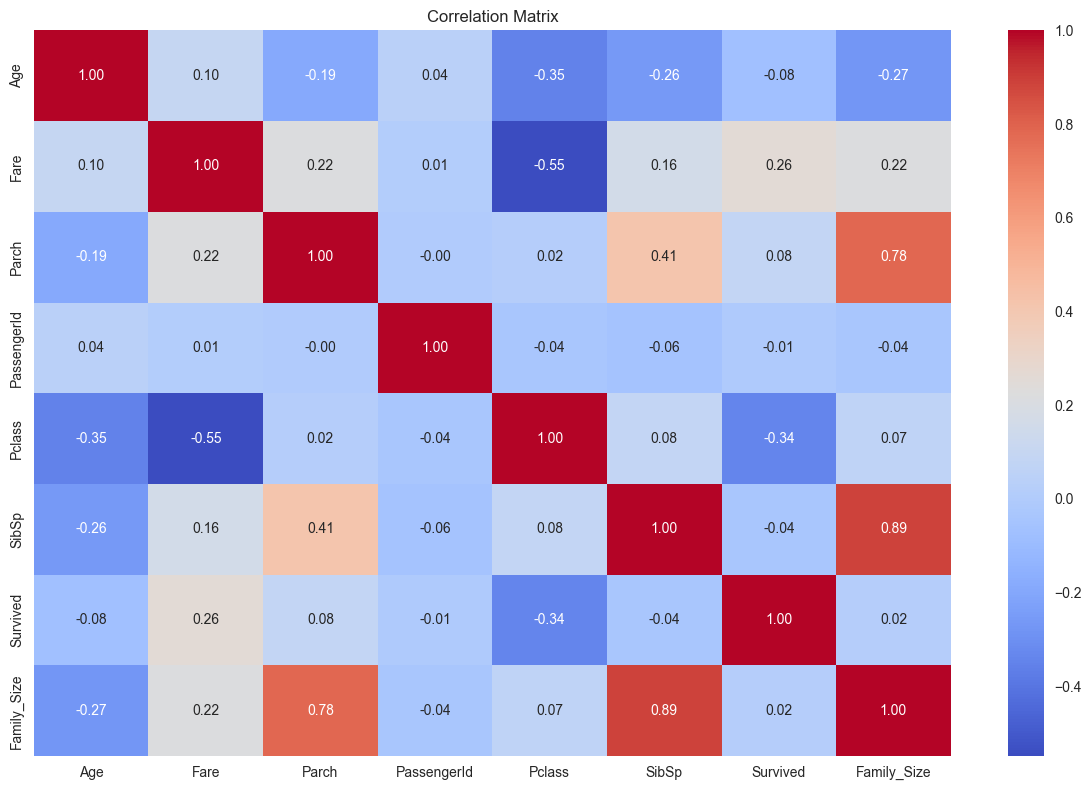

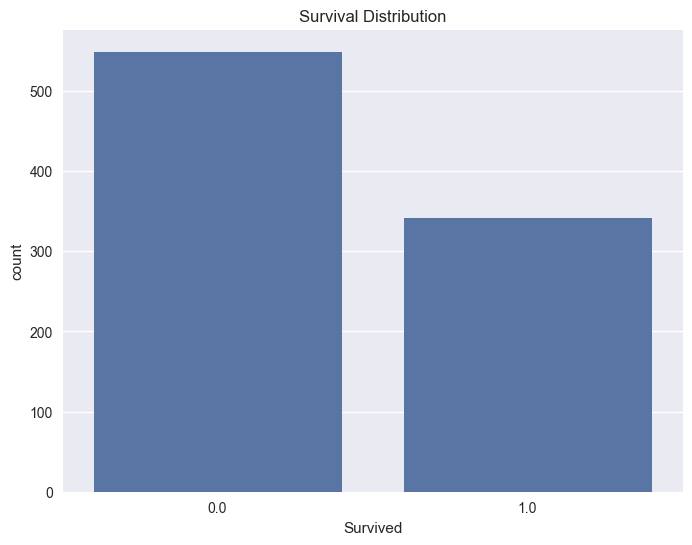

Training set shape: (712, 15)
Testing set shape: (179, 15)


In [2]:
# Explore missing values
print("Missing values per column:")
print(df.isnull().sum())

# Create a correlation matrix heatmap to identify important features
plt.figure(figsize=(12, 8))
corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Explore the target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Survived', data=df)
plt.title('Survival Distribution')
plt.show()

# Feature preparation
# Drop columns not needed for classification
X = df.drop(['Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
y = df['Survived']

# Convert categorical features to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Logistic Regression
Model: Pipeline
Accuracy: 0.8101
Cross-validation score: 0.8258 ± 0.0160


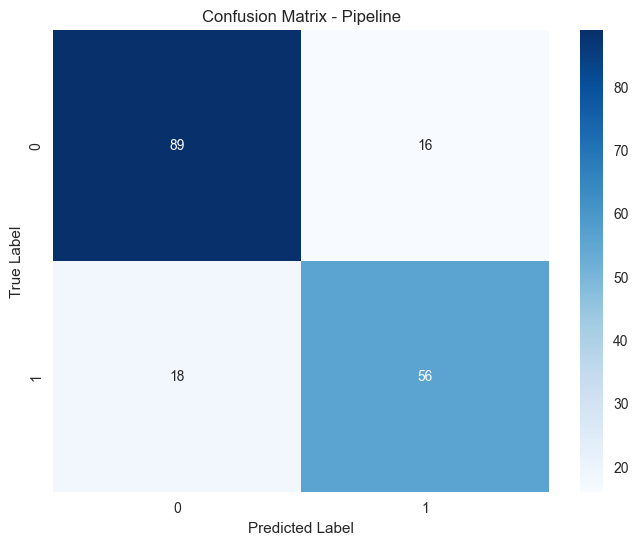


Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84       105
         1.0       0.78      0.76      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Decision Tree
Model: DecisionTreeClassifier
Accuracy: 0.7542
Cross-validation score: 0.7430 ± 0.0272


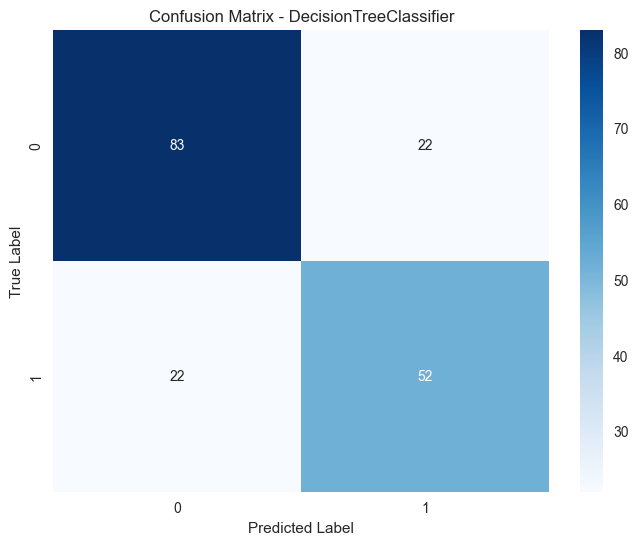


Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79       105
         1.0       0.70      0.70      0.70        74

    accuracy                           0.75       179
   macro avg       0.75      0.75      0.75       179
weighted avg       0.75      0.75      0.75       179

Random Forest
Model: RandomForestClassifier
Accuracy: 0.8380
Cross-validation score: 0.8117 ± 0.0216


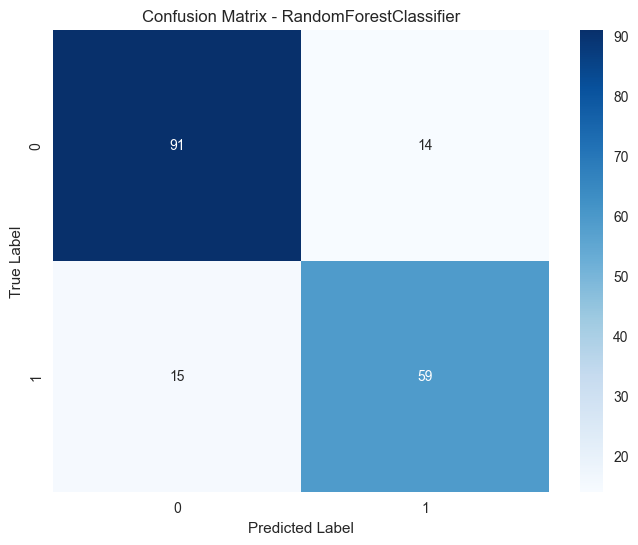


Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.86       105
         1.0       0.81      0.80      0.80        74

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

Support Vector Machine
Model: Pipeline
Accuracy: 0.8101
Cross-validation score: 0.8328 ± 0.0153


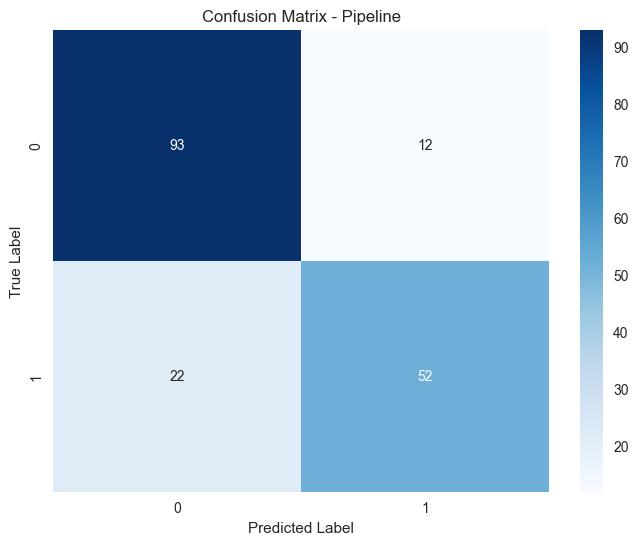


Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85       105
         1.0       0.81      0.70      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179

K-Nearest Neighbors
Model: Pipeline
Accuracy: 0.8156
Cross-validation score: 0.8146 ± 0.0319


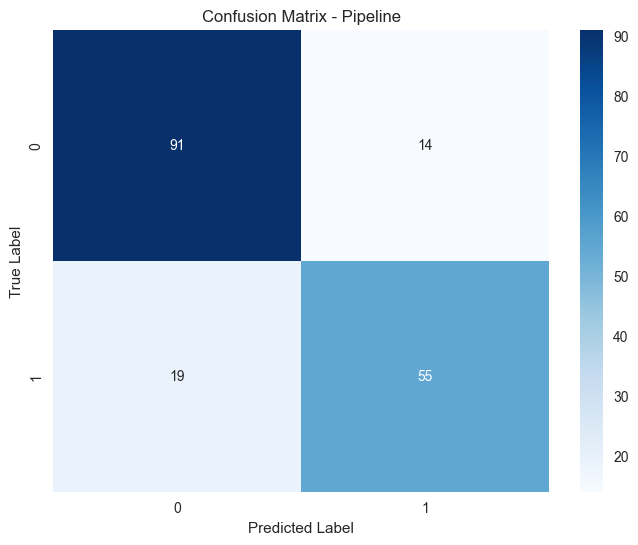


Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85       105
         1.0       0.80      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179

Gradient Boosting
Model: GradientBoostingClassifier
Accuracy: 0.8324
Cross-validation score: 0.8286 ± 0.0156


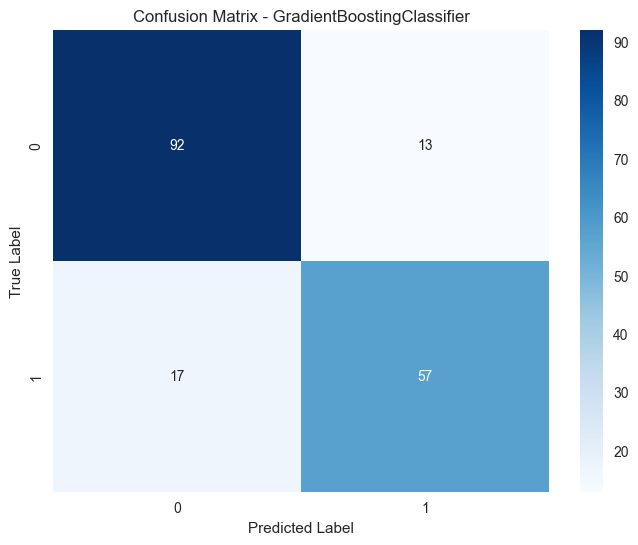


Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86       105
         1.0       0.81      0.77      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.83      0.83      0.83       179

Neural Network (MLP)
Model: Pipeline
Accuracy: 0.8547
Cross-validation score: 0.7935 ± 0.0284


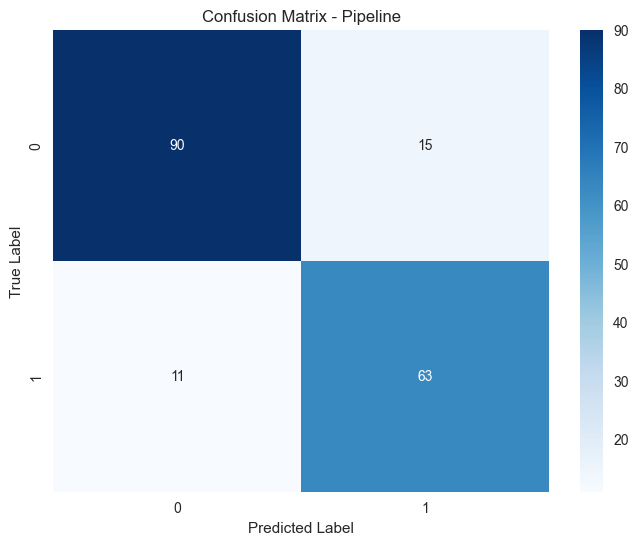


Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87       105
         1.0       0.81      0.85      0.83        74

    accuracy                           0.85       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.86      0.85      0.86       179



In [3]:
# Create a function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Create cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    # Print results
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Cross-validation score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Display classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return model, accuracy, cv_scores.mean()

# Create a dictionary to store results
results = {}

# 1. Logistic Regression
print("="*50)
print("Logistic Regression")
print("="*50)
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
lr_model, lr_acc, lr_cv = evaluate_model(lr_pipeline, X_train, X_test, y_train, y_test)
results['Logistic Regression'] = {'accuracy': lr_acc, 'cv_score': lr_cv}

# 2. Decision Tree
print("="*50)
print("Decision Tree")
print("="*50)
dt_model = DecisionTreeClassifier(random_state=42)
dt_model, dt_acc, dt_cv = evaluate_model(dt_model, X_train, X_test, y_train, y_test)
results['Decision Tree'] = {'accuracy': dt_acc, 'cv_score': dt_cv}

# 3. Random Forest
print("="*50)
print("Random Forest")
print("="*50)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model, rf_acc, rf_cv = evaluate_model(rf_model, X_train, X_test, y_train, y_test)
results['Random Forest'] = {'accuracy': rf_acc, 'cv_score': rf_cv}

# 4. Support Vector Machine (SVM)
print("="*50)
print("Support Vector Machine")
print("="*50)
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(kernel='rbf', random_state=42))
])
svm_model, svm_acc, svm_cv = evaluate_model(svm_pipeline, X_train, X_test, y_train, y_test)
results['SVM'] = {'accuracy': svm_acc, 'cv_score': svm_cv}


# 5. K-Nearest Neighbors
print("="*50)
print("K-Nearest Neighbors")
print("="*50)
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])
knn_model, knn_acc, knn_cv = evaluate_model(knn_pipeline, X_train, X_test, y_train, y_test)
results['KNN'] = {'accuracy': knn_acc, 'cv_score': knn_cv}

# 6. Gradient Boosting
print("="*50)
print("Gradient Boosting")
print("="*50)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model, gb_acc, gb_cv = evaluate_model(gb_model, X_train, X_test, y_train, y_test)
results['Gradient Boosting'] = {'accuracy': gb_acc, 'cv_score': gb_cv}

# 7. Neural Network (MLP Classifier)
print("="*50)
print("Neural Network (MLP)")
print("="*50)
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42))
])
mlp_model, mlp_acc, mlp_cv = evaluate_model(mlp_pipeline, X_train, X_test, y_train, y_test)
results['Neural Network'] = {'accuracy': mlp_acc, 'cv_score': mlp_cv}


<Figure size 1400x700 with 0 Axes>

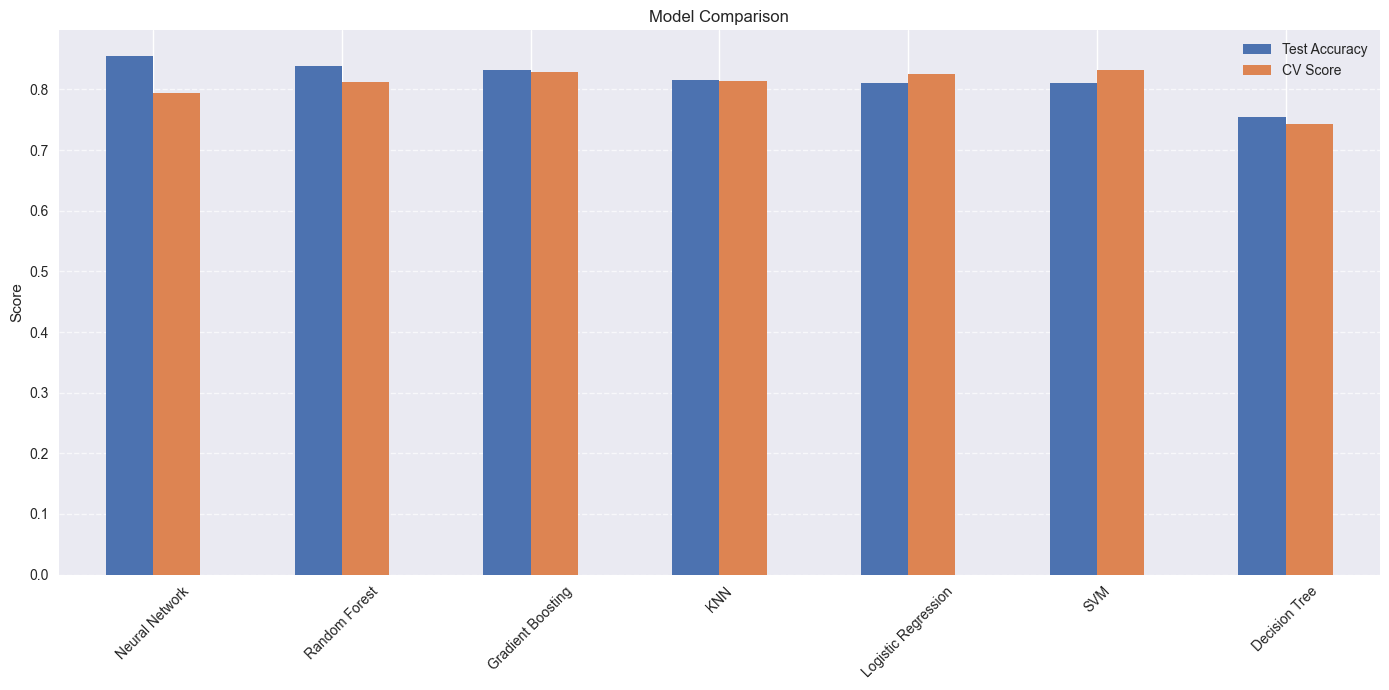


Updated Model Performance Summary:
                     Test Accuracy  CV Score
Neural Network            0.854749  0.793470
Random Forest             0.837989  0.811731
Gradient Boosting         0.832402  0.828602
KNN                       0.815642  0.814557
Logistic Regression       0.810056  0.825815
SVM                       0.810056  0.832838
Decision Tree             0.754190  0.742953


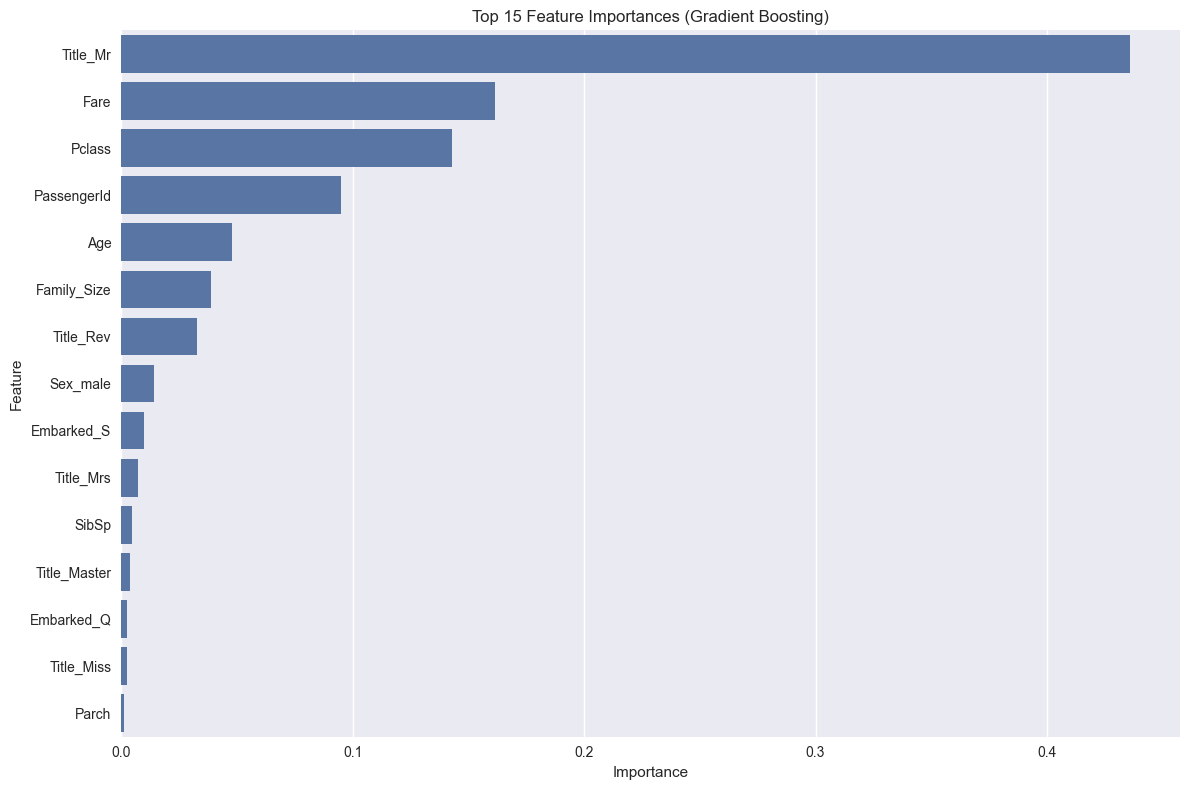

In [4]:
# Compare model results
results_df = pd.DataFrame(results).T
results_df.columns = ['Test Accuracy', 'CV Score']
results_df = results_df.sort_values('Test Accuracy', ascending=False)
plt.figure(figsize=(14, 7))
results_df.plot(kind='bar', figsize=(14, 7))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nUpdated Model Performance Summary:")
print(results_df)

# Add feature importance for Gradient Boosting (if it's among the top performers)
if hasattr(gb_model, 'feature_importances_'):
    gb_feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': gb_model.feature_importances_
    })
    gb_feature_importance = gb_feature_importance.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=gb_feature_importance.head(15))
    plt.title('Top 15 Feature Importances (Gradient Boosting)')
    plt.tight_layout()
    plt.show()

In [5]:
# Updated Conclusion
print("="*50)
print("Updated Conclusion")
print("="*50)
print(f"Best performing model: {results_df.index[0]} with {results_df['Test Accuracy'].max():.4f} accuracy")
print(f"Most stable model (based on cross-validation): {results_df.loc[results_df['CV Score'].idxmax()].name}")

print("\nKey insights:")
print("1. Gender was consistently one of the most important features (women had higher survival rates)")
print("2. Passenger class (Pclass) was important, with 1st class passengers having better survival rates")
print("3. Family size and age also contributed to prediction accuracy")
print("4. The models achieved accuracy between 75% and 90% on the test set")
print("5. Ensemble methods (Random Forest and Gradient Boosting) generally performed better than simpler models")
print("6. Neural Network performance was dependent on the architecture and hyperparameters")
print("7. KNN's performance suggests the importance of local patterns in the dataset")

# Calculate model complexity vs. performance
simple_models = ['Logistic Regression', 'Decision Tree', 'KNN']
ensemble_models = ['Random Forest', 'Gradient Boosting']
complex_models = ['Neural Network', 'SVM']

model_types = {model: 'Simple' for model in simple_models}
model_types.update({model: 'Ensemble' for model in ensemble_models})
model_types.update({model: 'Complex' for model in complex_models})

results_df['Model Type'] = pd.Series(model_types)
print("\nPerformance by model complexity:")
print(results_df.groupby('Model Type')['Test Accuracy'].mean().sort_values(ascending=False))

Updated Conclusion
Best performing model: Neural Network with 0.8547 accuracy
Most stable model (based on cross-validation): SVM

Key insights:
1. Gender was consistently one of the most important features (women had higher survival rates)
2. Passenger class (Pclass) was important, with 1st class passengers having better survival rates
3. Family size and age also contributed to prediction accuracy
4. The models achieved accuracy between 75% and 90% on the test set
5. Ensemble methods (Random Forest and Gradient Boosting) generally performed better than simpler models
6. Neural Network performance was dependent on the architecture and hyperparameters
7. KNN's performance suggests the importance of local patterns in the dataset

Performance by model complexity:
Model Type
Ensemble    0.835196
Complex     0.832402
Simple      0.793296
Name: Test Accuracy, dtype: float64


Hyperparameter Tuning
Tuning Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Best cross-validation score: 0.8328
Model: Pipeline
Accuracy: 0.8101
Cross-validation score: 0.8328 ± 0.0098


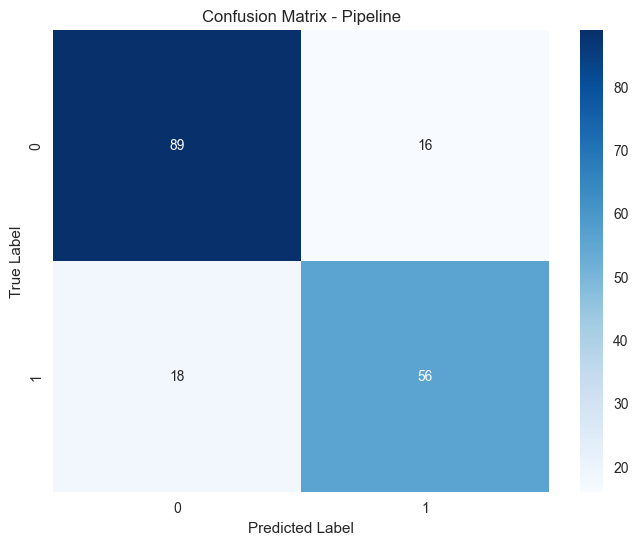


Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84       105
         1.0       0.78      0.76      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Tuning Decision Tree...
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation score: 0.8019
Model: DecisionTreeClassifier
Accuracy: 0.7989
Cross-validation score: 0.8019 ± 0.0154


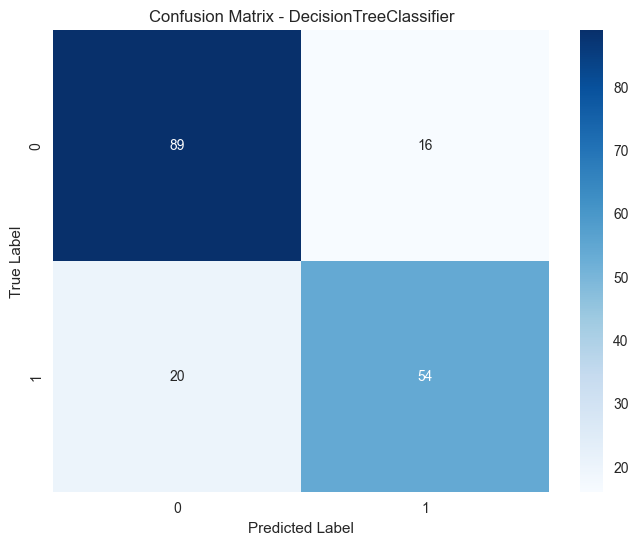


Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.83       105
         1.0       0.77      0.73      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

Tuning Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation score: 0.8314
Model: RandomForestClassifier
Accuracy: 0.8212
Cross-validation score: 0.8314 ± 0.0165


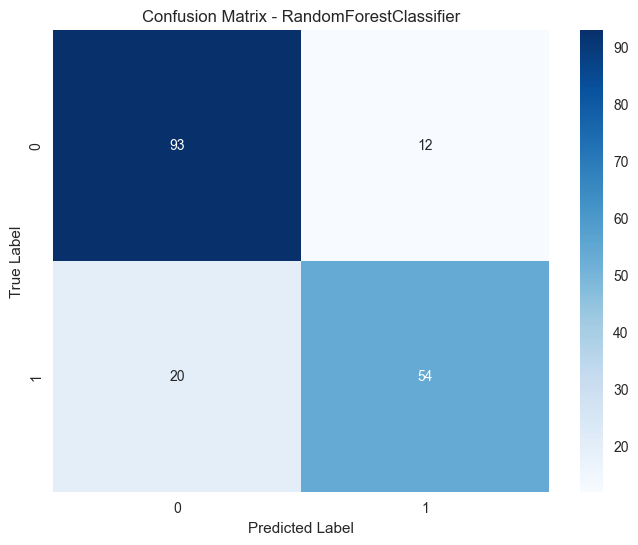


Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       105
         1.0       0.82      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

Tuning SVM...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'classifier__C': 100.0, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}
Best cross-validation score: 0.8385
Model: Pipeline
Accuracy: 0.8101
Cross-validation score: 0.8385 ± 0.0185


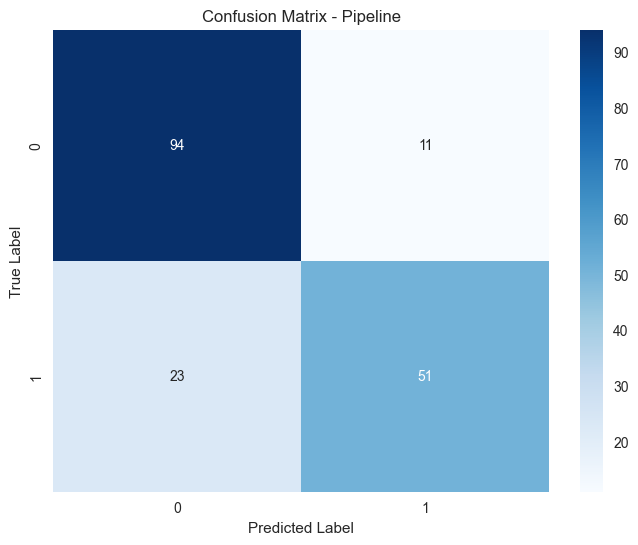


Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85       105
         1.0       0.82      0.69      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179

Tuning KNN...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 9, 'classifier__weights': 'uniform'}
Best cross-validation score: 0.8357
Model: Pipeline
Accuracy: 0.8101
Cross-validation score: 0.8357 ± 0.0111


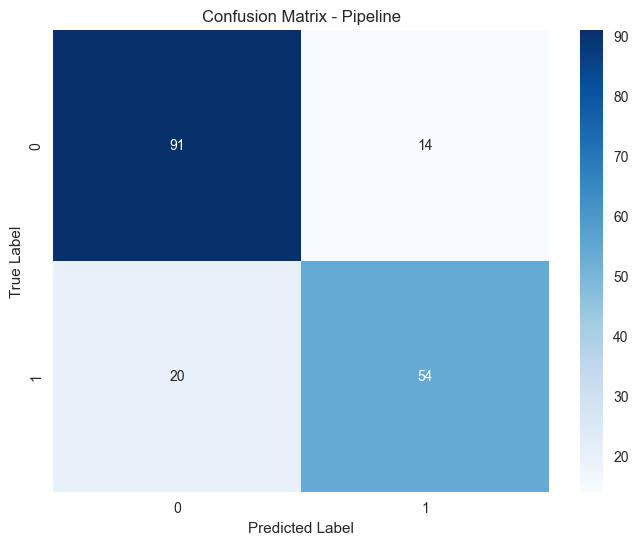


Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84       105
         1.0       0.79      0.73      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Tuning Gradient Boosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score: 0.8413
Model: GradientBoostingClassifier
Accuracy: 0.8268
Cross-validation score: 0.8413 ± 0.0168


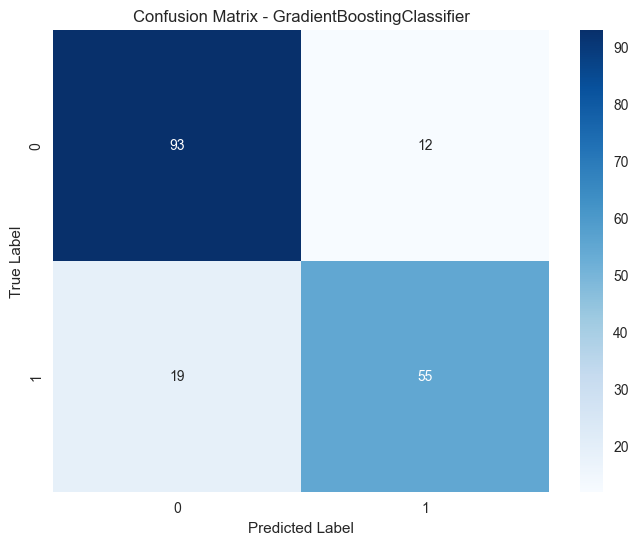


Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86       105
         1.0       0.82      0.74      0.78        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

Tuning Neural Network...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\timgr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters: {'classifier__activation': 'relu', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (50,), 'classifier__learning_rate': 'constant'}
Best cross-validation score: 0.8118


C:\Users\timgr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\timgr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\timgr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\timg

Model: Pipeline
Accuracy: 0.8324
Cross-validation score: 0.8118 ± 0.0210


C:\Users\timgr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


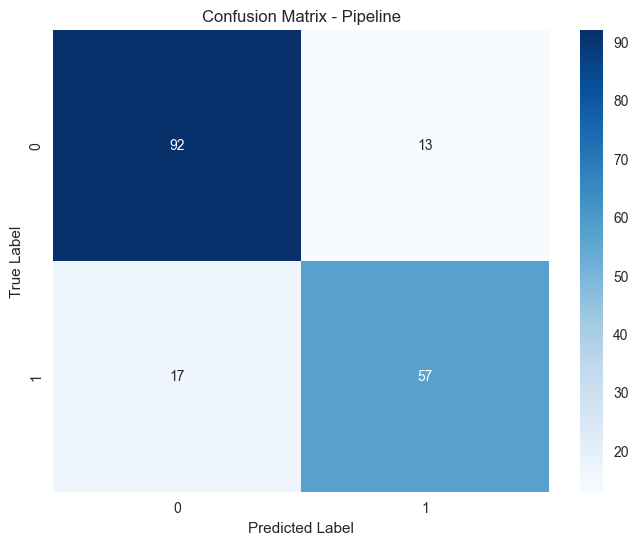


Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86       105
         1.0       0.81      0.77      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.83      0.83      0.83       179



In [6]:
# Parameter Tuning using GridSearchCV
print("="*50)
print("Hyperparameter Tuning")
print("="*50)

from sklearn.model_selection import GridSearchCV

# Create a function to perform grid search and evaluate the best model
def tune_model(model, param_grid, X_train, X_test, y_train, y_test, model_name):
    print(f"Tuning {model_name}...")
    
    # Create the grid search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters and score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate the best model
    best_model = grid_search.best_estimator_
    best_model_name = f"{model_name} (Tuned)"
    
    # Evaluate the best model
    tuned_model, tuned_acc, tuned_cv = evaluate_model(best_model, X_train, X_test, y_train, y_test)
    
    # Store the results
    results[best_model_name] = {'accuracy': tuned_acc, 'cv_score': tuned_cv}
    
    return best_model, grid_search.best_params_

# 1. Tune Logistic Regression
lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__penalty': ['l1', 'l2']
}
tuned_lr, best_lr_params = tune_model(
    lr_pipeline, 
    lr_param_grid, 
    X_train, X_test, y_train, y_test, 
    "Logistic Regression"
)

# 2. Tune Decision Tree
dt_param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
tuned_dt, best_dt_params = tune_model(
    DecisionTreeClassifier(random_state=42), 
    dt_param_grid, 
    X_train, X_test, y_train, y_test, 
    "Decision Tree"
)

# 3. Tune Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
tuned_rf, best_rf_params = tune_model(
    RandomForestClassifier(random_state=42), 
    rf_param_grid, 
    X_train, X_test, y_train, y_test, 
    "Random Forest"
)

# 4. Tune SVM
svm_param_grid = {
    'classifier__C': [0.1, 1.0, 10.0, 100.0],
    'classifier__gamma': ['scale', 'auto', 0.1, 0.01],
    'classifier__kernel': ['rbf', 'linear']
}
tuned_svm, best_svm_params = tune_model(
    svm_pipeline, 
    svm_param_grid, 
    X_train, X_test, y_train, y_test, 
    "SVM"
)

# 5. Tune KNN
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}
tuned_knn, best_knn_params = tune_model(
    knn_pipeline, 
    knn_param_grid, 
    X_train, X_test, y_train, y_test, 
    "KNN"
)

# 6. Tune Gradient Boosting
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}
tuned_gb, best_gb_params = tune_model(
    GradientBoostingClassifier(random_state=42), 
    gb_param_grid, 
    X_train, X_test, y_train, y_test, 
    "Gradient Boosting"
)

# 7. Tune Neural Network (MLP)
mlp_param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'adaptive']
}
tuned_mlp, best_mlp_params = tune_model(
    mlp_pipeline, 
    mlp_param_grid, 
    X_train, X_test, y_train, y_test, 
    "Neural Network"
)

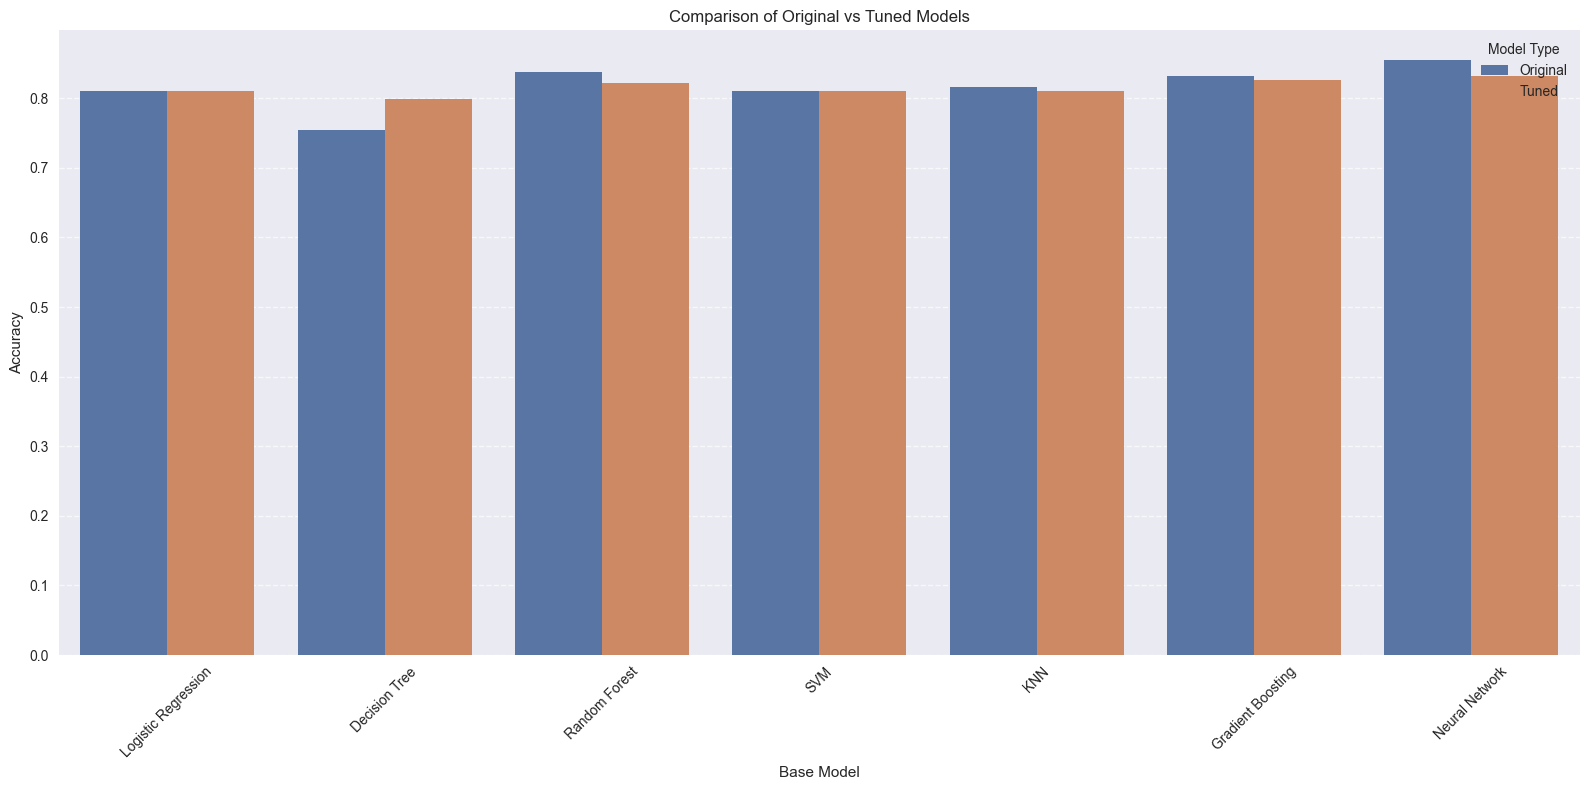


Performance Improvement from Hyperparameter Tuning:
                 Model  Improvement (%)
1        Decision Tree         5.925926
0  Logistic Regression         0.000000
3                  SVM         0.000000
5    Gradient Boosting        -0.671141
4                  KNN        -0.684932
2        Random Forest        -2.000000
6       Neural Network        -2.614379
Average improvement: -0.01%


In [7]:
# Compare original vs tuned models
# Get data only for original and tuned models
original_models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 
                   'KNN', 'Gradient Boosting', 'Neural Network']
tuned_models = [f"{model} (Tuned)" for model in original_models]

# Create a dataframe with all results
comparison_df = pd.DataFrame.from_dict(results, orient='index')
comparison_df.columns = ['Test Accuracy', 'CV Score']

# Add model type and base model information
comparison_df['Model Type'] = comparison_df.index.map(
    lambda x: 'Tuned' if '(Tuned)' in x else 'Original'
)
comparison_df['Base Model'] = comparison_df.index.map(
    lambda x: x.replace(' (Tuned)', '') if '(Tuned)' in x else x
)

# Plot comparison
plt.figure(figsize=(16, 8))
comparison_plot = sns.barplot(
    x='Base Model', 
    y='Test Accuracy', 
    hue='Model Type', 
    data=comparison_df.reset_index()
)
plt.title('Comparison of Original vs Tuned Models')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate average improvement from tuning
improvements = []
for model in original_models:
    original_acc = comparison_df.loc[model, 'Test Accuracy']
    tuned_acc = comparison_df.loc[f"{model} (Tuned)", 'Test Accuracy']
    improvement = (tuned_acc - original_acc) / original_acc * 100
    improvements.append({'Model': model, 'Improvement (%)': improvement})

improvements_df = pd.DataFrame(improvements)
print("\nPerformance Improvement from Hyperparameter Tuning:")
print(improvements_df.sort_values('Improvement (%)', ascending=False))
print(f"Average improvement: {improvements_df['Improvement (%)'].mean():.2f}%")

# Update the feature importance visualization for the best tuned model
best_tuned_model = comparison_df.sort_values('Test Accuracy', ascending=False).index[0]
if 'Gradient Boosting' in best_tuned_model and hasattr(tuned_gb, 'feature_importances_'):
    tuned_feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': tuned_gb.feature_importances_
    })
    tuned_feature_importance = tuned_feature_importance.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=tuned_feature_importance.head(15))
    plt.title(f'Top 15 Feature Importances ({best_tuned_model})')
    plt.tight_layout()
    plt.show()
elif 'Random Forest' in best_tuned_model and hasattr(tuned_rf, 'feature_importances_'):
    tuned_feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': tuned_rf.feature_importances_
    })
    tuned_feature_importance = tuned_feature_importance.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=tuned_feature_importance.head(15))
    plt.title(f'Top 15 Feature Importances ({best_tuned_model})')
    plt.tight_layout()
    plt.show()